In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time

from util import *
from data_loader import * 
import scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset={}
dataname = ['brain9k','brain1k','PBMC8k','PBMC68k','brain2k','brain1.3m']
dataset['brain9k'] = load_10x_9k() ## 9k brain cells 
dataset['brain1k'] = load_10x_1k() ## 1k brain cells 
dataset['PBMC8k'] = load_10x_8k() ## 8k PBMC cells 
dataset['PBMC68k'] = load_10x_68k() ## 68k PBMC cells 
dataset['brain2k'] = load_10x_2k() ## 2k brain cells 
dataset['brain1.3m'] = load_10x_1_3mil() ## 1.3 million brain cells 

# estimation consistency

In [3]:
M,M_ml,M_nsf,M_ml_nsf,gene_list,gene_list_nsf = {},{},{},{},{},{}

for dname in dataset.keys():
#     if dname=='brain1.3m': break
    print('## processing %s ...'%dname)
    print('# n_cell=%d, n_gene=%d'%(dataset[dname].shape[0],dataset[dname].shape[1]))
    temp = dataset[dname].copy()
    sc.pp.filter_cells(temp, min_counts=0.01*temp.shape[1])
    gamma_c = sd.sf(temp,verbose=False)
    sc.pp.filter_genes(temp,min_counts=0.01*temp.shape[0])
    print('# after filtering: n_cell=%d, n_gene=%d'%(temp.shape[0],temp.shape[1]))
    M_,M_ml_,gene_list_ = sd.dd_moment_anndata(temp,gamma_c=gamma_c,verbose=False)
    M_nsf_,M_ml_nsf_,gene_list_nsf_ = sd.dd_moment_anndata(temp,gamma_c=None,verbose=False)
    
    M[dname],M_ml[dname],M_nsf[dname],M_ml_nsf[dname],gene_list[dname],gene_list_nsf[dname] = \
    M_,M_ml_,M_nsf_,M_ml_nsf_,gene_list_,gene_list_nsf_
    print('\n')
#     if dname=='PBMC8k': break

## processing brain9k ...
# n_cell=9128, n_gene=27998
# after filtering: n_cell=9128, n_gene=12484


## processing brain1k ...
# n_cell=931, n_gene=27998
# after filtering: n_cell=931, n_gene=12343


## processing PBMC8k ...
# n_cell=8381, n_gene=33694
# after filtering: n_cell=8381, n_gene=11062


## processing PBMC68k ...
# n_cell=68579, n_gene=32738
# after filtering: n_cell=68579, n_gene=6723


## processing brain2k ...
# n_cell=2022, n_gene=27998
# after filtering: n_cell=2022, n_gene=12305


## processing brain1.3m ...
# n_cell=1306127, n_gene=27998
# after filtering: n_cell=1306127, n_gene=11930




In [4]:
## change all the gene names to upper-case 
for gl in gene_list.keys():
    temp = gene_list[gl]
    for i in range(len(temp)):
        temp[i] = temp[i].upper()
    gene_list[gl] = temp
for gl in gene_list.keys():
    temp = gene_list_nsf[gl]
    for i in range(len(temp)):
        temp[i] = temp[i].upper()
    gene_list_nsf[gl] = temp

## brain1k vs brain2k
ml: above=853, below=327, avg_r log10(cv2/cv1)=0.043
dd: above=304, below=876, avg_r log10(cv2/cv1)=-0.159


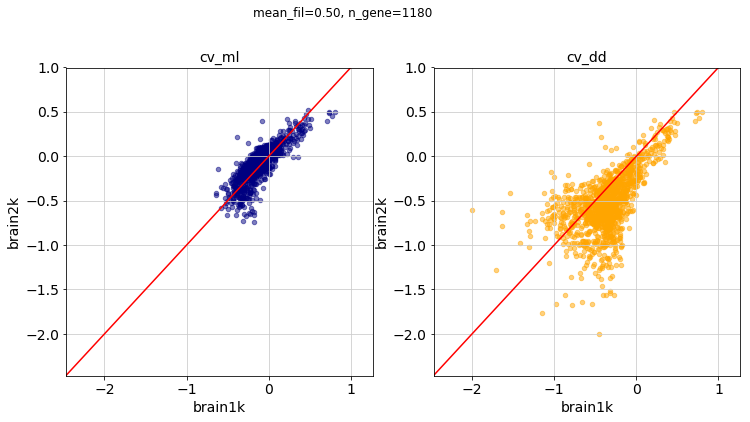

## brain1k vs brain9k
ml: above=1381, below=163, avg_r log10(cv2/cv1)=0.095
dd: above=877, below=667, avg_r log10(cv2/cv1)=0.026


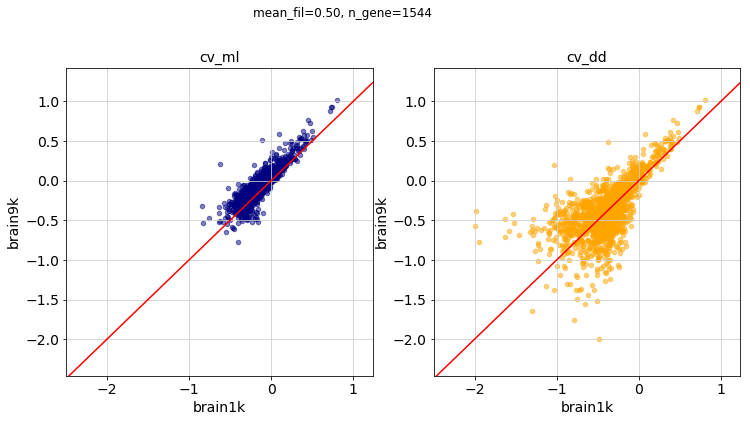

## brain1k vs brain1.3m
ml: above=998, below=63, avg_r log10(cv2/cv1)=0.148
dd: above=638, below=423, avg_r log10(cv2/cv1)=0.038


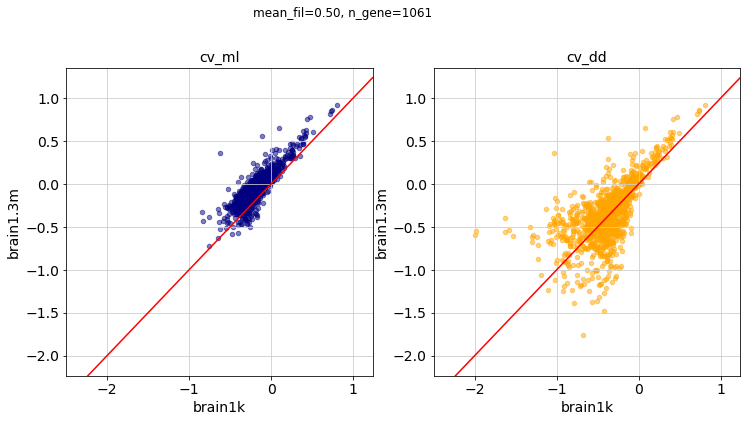

In [5]:
plot_list = [['brain9k','brain1k'],['brain9k','brain2k'],['brain9k','brain1.3m']]
plot_list = [['brain1k','brain2k'],['brain1k','brain9k'],['brain1k','brain1.3m']]
# plot_list = [['brain9k','brain1k']]
for pair in plot_list:    
    d1,d2=pair
    print('## %s vs %s'%(d1,d2))
    sd.fig_xx_cv(M[d1],M_ml[d1],M[d2],M_ml[d2],gene_list[d1],gene_list[d2],[d1,d2],mean_fil=0.5)    
#     sd.fig_xx_cv(M_nsf[d1],M_ml_nsf[d1],M_nsf[d2],M_ml_nsf[d2],gene_list_nsf[d1],gene_list_nsf[d2],[d1,d2],mean_fil=0.5)

# high vs low experiments 

In [266]:
dataset.keys()

dict_keys(['brain9k', 'brain1k', 'PBMC8k', 'PBMC68k', 'brain2k', 'brain1.3m'])

### the sequencing depth seems to be 
1k > 9k > 2k > 1.3m

In [ ]:
## generate a mean sequencing depth plot 
plt.figure(figsize=[18,5])
bins = np.linspace(-1,4,20)
for dname in ['brain1k','brain2k','brain9k','brain1.3m']:
    data = dataset[dname].copy()
    sc.pp.filter_genes(data,min_counts=0.1*data.shape[0])
    mean_g = np.array(data.X.mean(axis=0),dtype=float).reshape(-1)
    plt.hist(np.log10(mean_g),alpha=0.3,bins=bins,label=dname)
plt.legend()
plt.show()

In [407]:
d_deep = 'brain1k'
d_shallow = 'brain1.3m'
gene_list_ = []
idx_deep = []
idx_shallow = []

for gene in gene_list[d_deep]:   
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if (M_ml_nsf[d_shallow][temp_shallow,0]<1) and (M_ml_nsf[d_deep][temp_deep,0]>2):
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,M_ml_nsf[d_shallow][temp_shallow,0],
                M[d_deep][temp_deep,0]))

gene: SNHG6, mean_shallow=0.527, mean_deep=2.009
gene: NDUFB3, mean_shallow=0.931, mean_deep=2.643
gene: IGFBP2, mean_shallow=0.825, mean_deep=2.267
gene: NDUFA10, mean_shallow=0.967, mean_deep=2.551
gene: NUCKS1, mean_shallow=0.872, mean_deep=2.016
gene: CNTN2, mean_shallow=0.768, mean_deep=2.544
gene: BTG2, mean_shallow=0.707, mean_deep=2.076
gene: GLRX2, mean_shallow=0.756, mean_deep=2.034
gene: MRPS14, mean_shallow=0.767, mean_deep=2.014
gene: PRDX6, mean_shallow=0.936, mean_deep=2.185
gene: MPC2, mean_shallow=0.906, mean_deep=2.626
gene: NDUFS2, mean_shallow=0.883, mean_deep=2.504
gene: IGSF8, mean_shallow=0.621, mean_deep=2.075
gene: FRMD4A, mean_shallow=0.967, mean_deep=2.176
gene: NPDC1, mean_shallow=0.875, mean_deep=2.431
gene: PSMD14, mean_shallow=0.963, mean_deep=2.214
gene: SSRP1, mean_shallow=0.869, mean_deep=2.356
gene: MTCH2, mean_shallow=0.969, mean_deep=2.753
gene: NDUFS3, mean_shallow=0.900, mean_deep=2.361
gene: PSMC3, mean_shallow=0.796, mean_deep=2.085
gene: CCDC34

gene: COX14, mean_shallow=0.944, mean_deep=2.571
gene: UBE2L3, mean_shallow=0.936, mean_deep=2.820
gene: 0610012G03RIK, mean_shallow=0.909, mean_deep=2.229
gene: PPP2R1A, mean_shallow=0.950, mean_deep=2.489
gene: STUB1, mean_shallow=0.927, mean_deep=2.293
gene: MRPL28, mean_shallow=0.797, mean_deep=2.105
gene: ATP6V0E, mean_shallow=0.896, mean_deep=2.364
gene: PFDN6, mean_shallow=0.986, mean_deep=2.568
gene: CSNK2B, mean_shallow=0.874, mean_deep=2.255
gene: PPP1R11, mean_shallow=0.742, mean_deep=2.117
gene: DPY30, mean_shallow=0.866, mean_deep=2.266
gene: PFDN1, mean_shallow=0.967, mean_deep=2.261
gene: LMNB1, mean_shallow=0.958, mean_deep=2.004
gene: TXNL1, mean_shallow=0.970, mean_deep=2.121
gene: IER3IP1, mean_shallow=0.858, mean_deep=2.039
gene: CYB5A, mean_shallow=0.941, mean_deep=2.315
gene: DRAP1, mean_shallow=0.629, mean_deep=2.551
gene: NXF1, mean_shallow=0.981, mean_deep=2.527
gene: PRPF19, mean_shallow=0.820, mean_deep=2.021
gene: GM9493, mean_shallow=0.551, mean_deep=2.303


ml: above=116, below=0, avg_r log10(cv2/cv1)=0.193
dd: above=65, below=51, avg_r log10(cv2/cv1)=-0.023


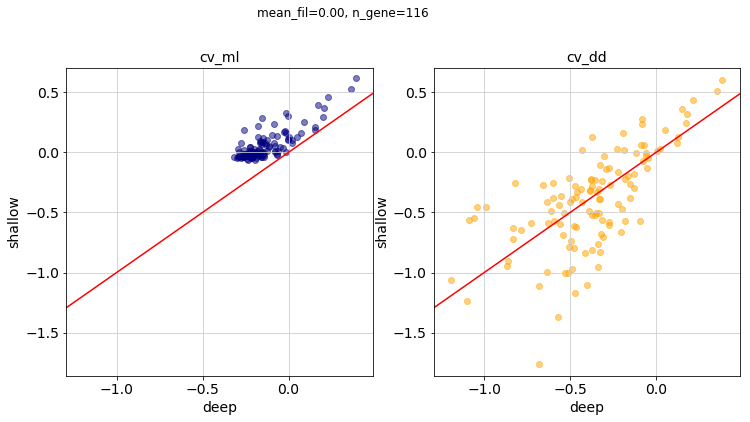

In [408]:
sd.fig_xx_cv(M[d_deep][idx_deep,:],M_ml[d_deep][idx_deep,:],
             M[d_shallow][idx_shallow,:],M_ml[d_shallow][idx_shallow,:],
             gene_list_,gene_list_,['deep','shallow'],mean_fil=0,s=None,margin=0.1)    

### try another two...

In [411]:
d_deep = 'brain1k'
d_shallow = 'brain9k'
gene_list_ = []
idx_deep = []
idx_shallow = []

for gene in gene_list[d_deep]:   
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if (M_ml_nsf[d_shallow][temp_shallow,0]<1.5) and (M_ml_nsf[d_deep][temp_deep,0]>2):
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,M_ml_nsf[d_shallow][temp_shallow,0],
                M[d_deep][temp_deep,0]))

gene: SNHG6, mean_shallow=0.919, mean_deep=2.009
gene: EIF5B, mean_shallow=1.450, mean_deep=2.348
gene: NDUFB3, mean_shallow=1.489, mean_deep=2.643
gene: IGFBP2, mean_shallow=1.379, mean_deep=2.267
gene: HES6, mean_shallow=1.464, mean_deep=2.841
gene: NDUFA10, mean_shallow=1.426, mean_deep=2.551
gene: NUCKS1, mean_shallow=1.119, mean_deep=2.016
gene: CNTN2, mean_shallow=1.114, mean_deep=2.544
gene: BTG2, mean_shallow=0.773, mean_deep=2.076
gene: GLRX2, mean_shallow=1.085, mean_deep=2.034
gene: MRPS14, mean_shallow=1.158, mean_deep=2.014
gene: NDUFS2, mean_shallow=1.364, mean_deep=2.504
gene: IGSF8, mean_shallow=1.020, mean_deep=2.075
gene: FRMD4A, mean_shallow=1.293, mean_deep=2.176
gene: NPDC1, mean_shallow=1.434, mean_deep=2.431
gene: PSMD14, mean_shallow=1.366, mean_deep=2.214
gene: ZC3H15, mean_shallow=1.275, mean_deep=2.350
gene: SSRP1, mean_shallow=1.273, mean_deep=2.356
gene: NDUFS3, mean_shallow=1.337, mean_deep=2.361
gene: PSMC3, mean_shallow=1.133, mean_deep=2.085
gene: CCDC3

gene: DPY30, mean_shallow=1.357, mean_deep=2.266
gene: KIF5B, mean_shallow=1.460, mean_deep=2.303
gene: PFDN1, mean_shallow=1.467, mean_deep=2.261
gene: LMNB1, mean_shallow=1.435, mean_deep=2.004
gene: TXNL1, mean_shallow=1.462, mean_deep=2.121
gene: IER3IP1, mean_shallow=1.300, mean_deep=2.039
gene: DRAP1, mean_shallow=1.002, mean_deep=2.551
gene: NXF1, mean_shallow=1.351, mean_deep=2.527
gene: PRPF19, mean_shallow=1.240, mean_deep=2.021
gene: GM9493, mean_shallow=1.196, mean_deep=2.303
gene: BBIP1, mean_shallow=1.441, mean_deep=2.249
gene: RPS12-PS3, mean_shallow=0.462, mean_deep=2.373


ml: above=113, below=6, avg_r log10(cv2/cv1)=0.124
dd: above=67, below=52, avg_r log10(cv2/cv1)=0.003


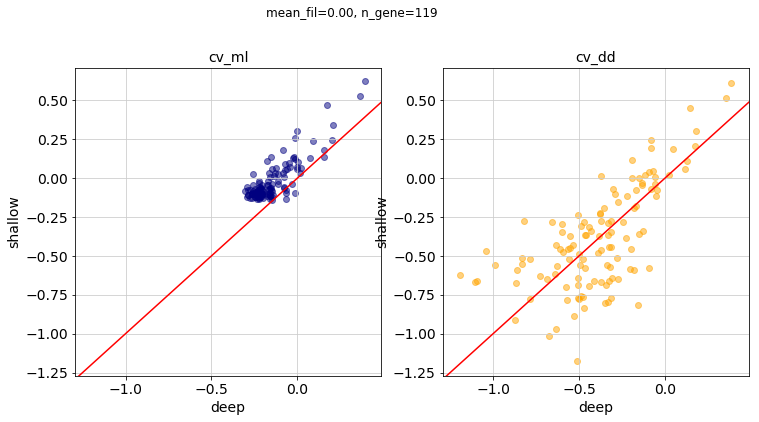

In [412]:
sd.fig_xx_cv(M[d_deep][idx_deep,:],M_ml[d_deep][idx_deep,:],
             M[d_shallow][idx_shallow,:],M_ml[d_shallow][idx_shallow,:],
             gene_list_,gene_list_,['deep','shallow'],mean_fil=0,s=None,margin=0.1)    

In [413]:
d_deep = 'brain1k'
d_shallow = 'brain2k'
gene_list_ = []
idx_deep = []
idx_shallow = []

for gene in gene_list[d_deep]:   
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if (M_ml_nsf[d_shallow][temp_shallow,0]<1.5) and (M_ml_nsf[d_deep][temp_deep,0]>2):
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,M_ml_nsf[d_shallow][temp_shallow,0],
                M[d_deep][temp_deep,0]))

gene: SNHG6, mean_shallow=0.423, mean_deep=2.009
gene: EIF5B, mean_shallow=1.162, mean_deep=2.348
gene: POU3F3, mean_shallow=1.493, mean_deep=2.571
gene: NDUFB3, mean_shallow=1.148, mean_deep=2.643
gene: IDH1, mean_shallow=1.492, mean_deep=2.061
gene: IGFBP2, mean_shallow=1.189, mean_deep=2.267
gene: NUCKS1, mean_shallow=0.857, mean_deep=2.016
gene: CNTN2, mean_shallow=0.992, mean_deep=2.544
gene: BTG2, mean_shallow=1.356, mean_deep=2.076
gene: GLRX2, mean_shallow=1.405, mean_deep=2.034
gene: MRPS14, mean_shallow=1.409, mean_deep=2.014
gene: PRDX6, mean_shallow=1.394, mean_deep=2.185
gene: MPC2, mean_shallow=1.102, mean_deep=2.626
gene: PBX1, mean_shallow=1.205, mean_deep=3.212
gene: IGSF8, mean_shallow=1.088, mean_deep=2.075
gene: ZBTB18, mean_shallow=1.358, mean_deep=2.604
gene: SRP9, mean_shallow=1.319, mean_deep=2.664
gene: FRMD4A, mean_shallow=0.906, mean_deep=2.176
gene: NPDC1, mean_shallow=1.254, mean_deep=2.431
gene: ZEB2, mean_shallow=0.856, mean_deep=2.291
gene: DYNC1I2, mean

gene: PRPF19, mean_shallow=1.076, mean_deep=2.021
gene: GM9493, mean_shallow=1.331, mean_deep=2.303
gene: BBIP1, mean_shallow=1.166, mean_deep=2.249
gene: RPS12-PS3, mean_shallow=0.612, mean_deep=2.373
gene: MT-ND3, mean_shallow=1.333, mean_deep=3.566


ml: above=85, below=14, avg_r log10(cv2/cv1)=0.098
dd: above=23, below=76, avg_r log10(cv2/cv1)=-0.156


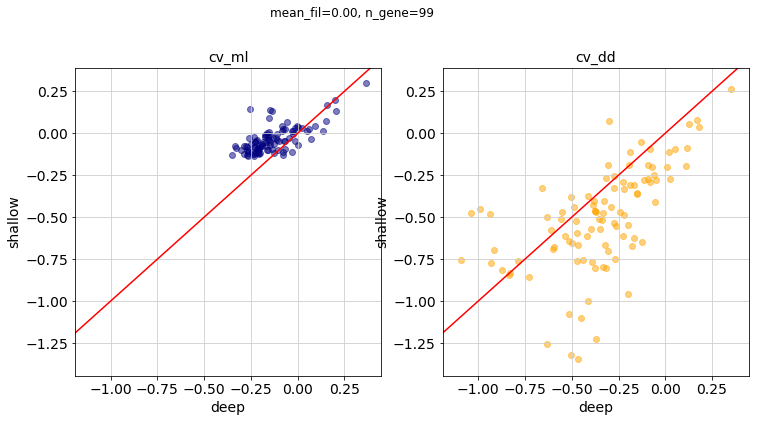

In [414]:
sd.fig_xx_cv(M[d_deep][idx_deep,:],M_ml[d_deep][idx_deep,:],
             M[d_shallow][idx_shallow,:],M_ml[d_shallow][idx_shallow,:],
             gene_list_,gene_list_,['deep','shallow'],mean_fil=0,s=None,margin=0.1)    

In [424]:
d_deep = 'brain2k'
d_shallow = 'brain1k'
gene_list_ = []
idx_deep = []
idx_shallow = []

for gene in gene_list[d_deep]:   
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if (M_ml_nsf[d_shallow][temp_shallow,0]<1) and (M_ml_nsf[d_deep][temp_deep,0]>1.5):
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,M_ml_nsf[d_shallow][temp_shallow,0],
                M[d_deep][temp_deep,0]))

gene: GRCC10, mean_shallow=0.852, mean_deep=1.800
gene: APOE, mean_shallow=0.814, mean_deep=2.068
gene: GM10116, mean_shallow=0.243, mean_deep=2.397
gene: MT-ATP8, mean_shallow=0.643, mean_deep=2.412


ml: above=3, below=0, avg_r log10(cv2/cv1)=0.221
dd: above=2, below=1, avg_r log10(cv2/cv1)=0.033


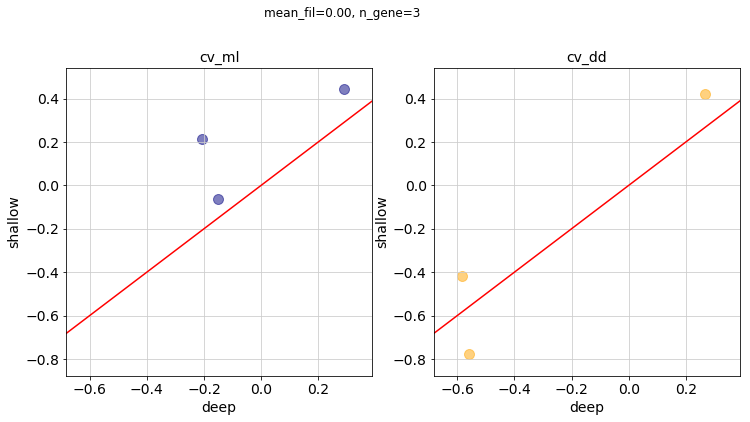

In [425]:
sd.fig_xx_cv(M[d_deep][idx_deep,:],M_ml[d_deep][idx_deep,:],
             M[d_shallow][idx_shallow,:],M_ml[d_shallow][idx_shallow,:],
             gene_list_,gene_list_,['deep','shallow'],mean_fil=0,s=100,margin=0.1)    

In [380]:
d_deep = 'PBMC8k'
d_shallow = 'PBMC68k'
gene_list_ = []
idx_deep = []
idx_shallow = []
data_deep = dataset[d_deep].copy()
sc.pp.filter_genes(data_deep,min_counts=2*data_deep.shape[0])

for gene in data_deep.var_names: 
    if (gene.upper() in gene_list[d_deep]) and (gene.upper() in gene_list[d_shallow]):
        temp_deep = gene_list[d_deep].index(gene.upper())
        temp_shallow = gene_list[d_shallow].index(gene.upper())
    else: 
        continue
    if M_ml_nsf[d_shallow][temp_shallow,0]<2:
        gene_list_.append(gene)
        idx_deep.append(temp_deep)
        idx_shallow.append(temp_shallow)
        print('gene: %s, mean_shallow=%0.3f, mean_deep=%0.3f'
              %(gene,M_ml_nsf[d_shallow][temp_shallow,0],
                M[d_deep][temp_deep,0]))

gene: RPL22, mean_shallow=1.345, mean_deep=9.018
gene: CDC42, mean_shallow=0.151, mean_deep=2.247
gene: LAPTM5, mean_shallow=0.617, mean_deep=3.061
gene: YBX1, mean_shallow=1.445, mean_deep=3.569
gene: JUN, mean_shallow=1.243, mean_deep=5.684
gene: TXNIP, mean_shallow=0.890, mean_deep=3.033
gene: CTSS, mean_shallow=0.337, mean_deep=4.464
gene: S100A10, mean_shallow=0.860, mean_deep=2.599
gene: S100A11, mean_shallow=0.402, mean_deep=2.592
gene: S100A9, mean_shallow=0.299, mean_deep=16.659
gene: S100A8, mean_shallow=0.208, mean_deep=13.682
gene: S100A6, mean_shallow=1.513, mean_deep=9.360
gene: FCER1G, mean_shallow=0.435, mean_deep=2.880
gene: PTPRC, mean_shallow=0.403, mean_deep=2.643
gene: H3F3A, mean_shallow=0.131, mean_deep=5.891
gene: OST4, mean_shallow=0.576, mean_deep=2.357
gene: ZFP36L2, mean_shallow=0.610, mean_deep=2.881
gene: CALM2, mean_shallow=0.509, mean_deep=2.672
gene: CXCR4, mean_shallow=0.377, mean_deep=2.074
gene: NBEAL1, mean_shallow=0.375, mean_deep=2.944
gene: ARPC2

ml: above=108, below=3, avg_r log10(cv2/cv1)=0.272
dd: above=87, below=24, avg_r log10(cv2/cv1)=0.169


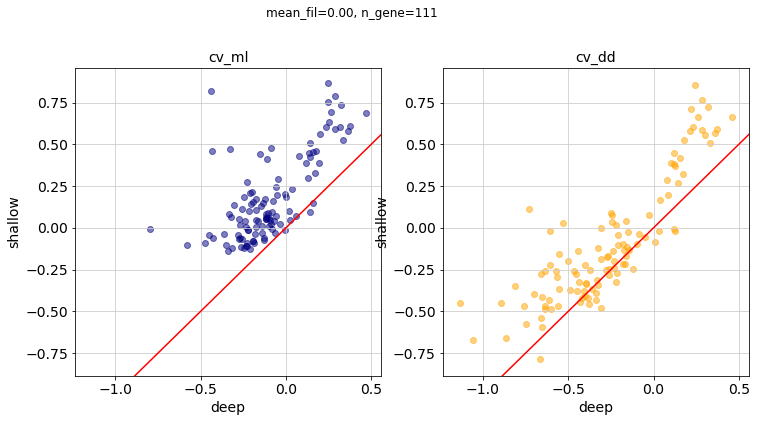

In [381]:
sd.fig_xx_cv(M[d_deep][idx_deep,:],M_ml[d_deep][idx_deep,:],
             M[d_shallow][idx_shallow,:],M_ml[d_shallow][idx_shallow,:],
             gene_list_,gene_list_,['deep','shallow'],mean_fil=0,s=None,margin=0.1)    

# behaviours of low count genes 

In [143]:
X = dataset['brain1k'].copy().X
Nrc = np.array(X.sum(axis=1),dtype=int)
Nr = Nrc.mean()
g_ml = Nrc/Nr
print('ml',(g_ml**2).mean())
print('dd',((Nrc**2).mean()-Nrc.mean())/Nr**2)


ml 1.6218973700339285
dd 1.621810551688494


Nr=7332
gamma_c [0.3020941  0.3020941  0.30361167 3.06614736 5.08897634 7.90790987]


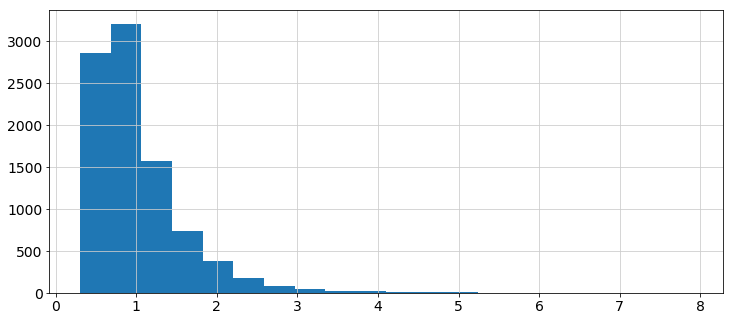

#time start: 0.0s
n_cell=9128, n_gene=1188


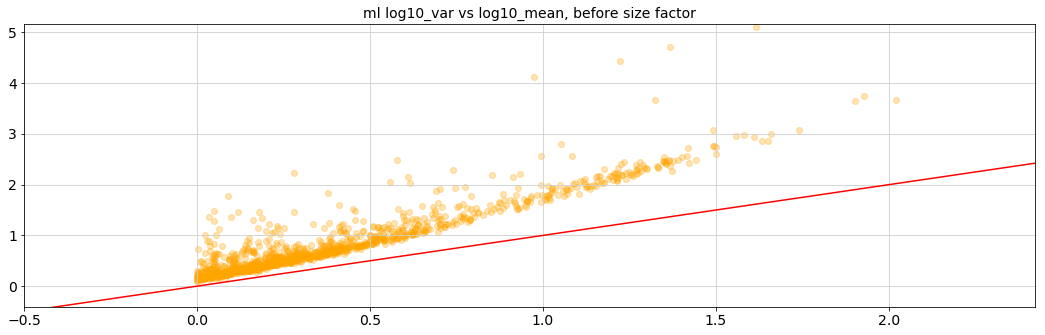

M1, sf=1.0000
M2, sf=1.3507
#time total: 0.6886s



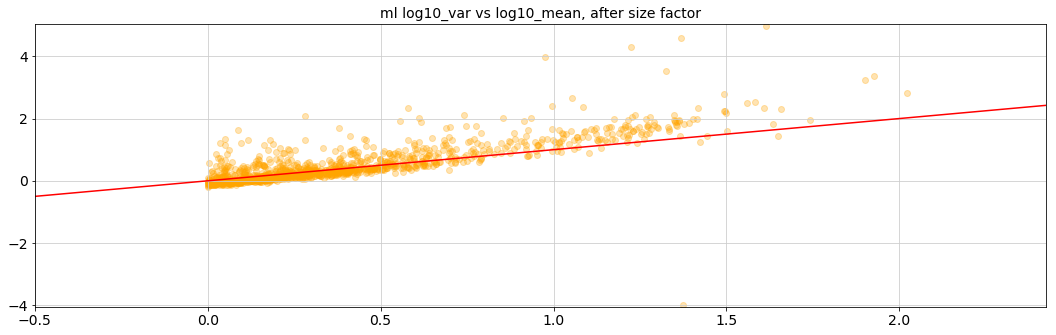

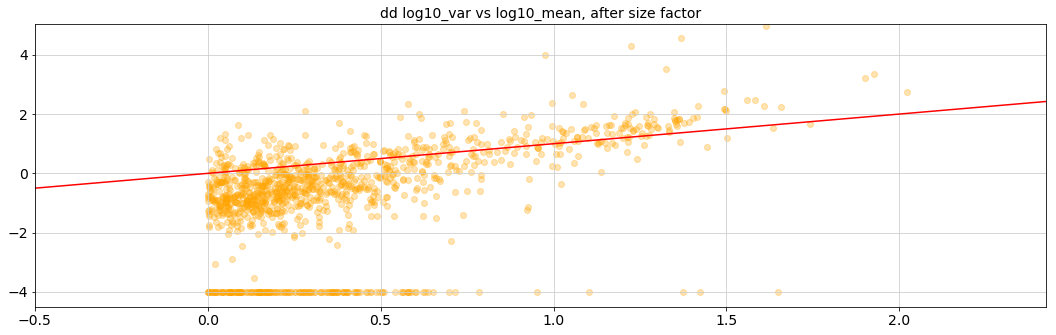

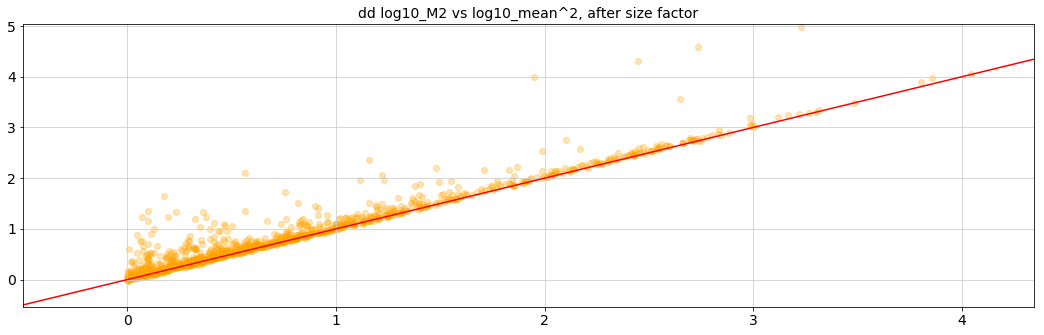

In [232]:
data_9k = dataset['brain9k'].copy()
sf_9k = sd.sf(data_9k,verbose=True)
sc.pp.filter_genes(data_9k,min_counts=1*data_9k.shape[0])
M_9k,M_ml_9k,gene_list_9k = sd.dd_moment_anndata(data_9k,gamma_c=sf_9k,verbose=True)

Nr=7590
gamma_c [0.29522318 0.29562254 0.29734204 2.87913475 5.29541401 5.88101435]


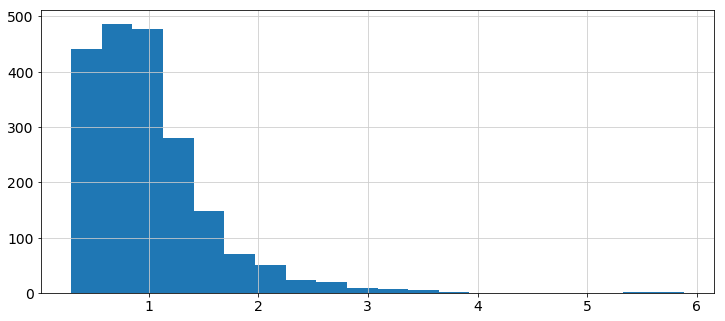

#time start: 0.0s
n_cell=2022, n_gene=1207


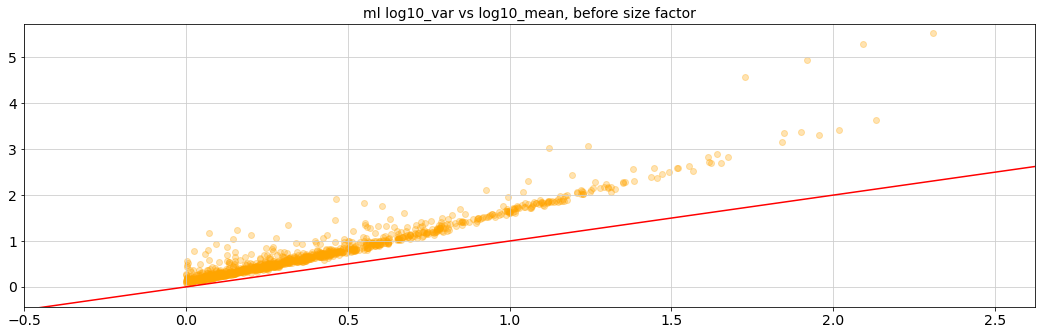

M1, sf=1.0000
M2, sf=1.3109
#time total: 0.3809s



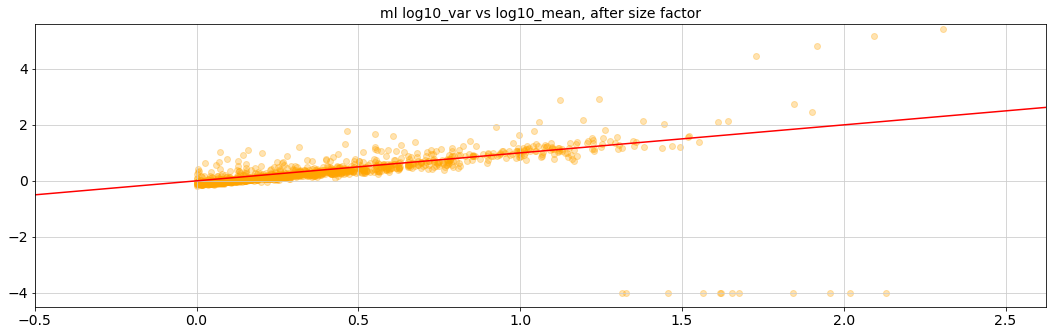

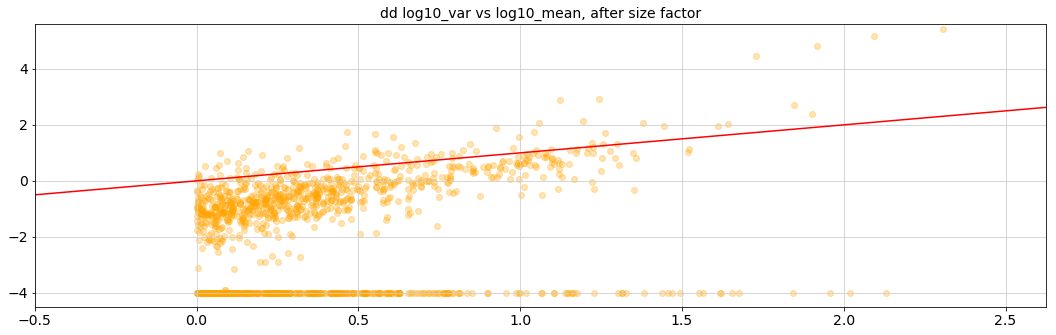

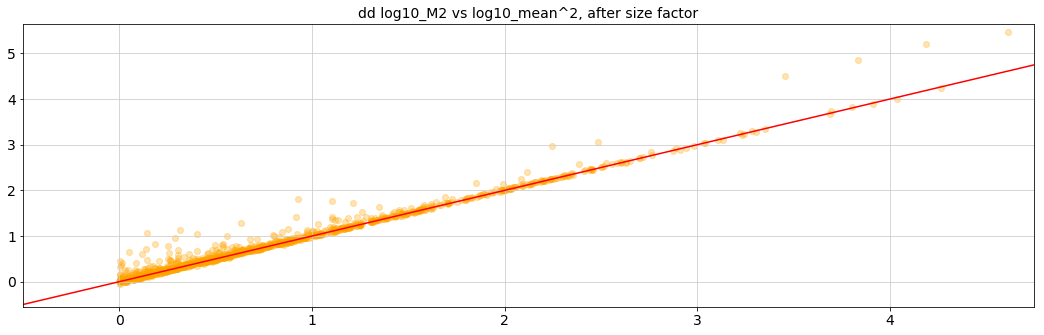

In [244]:
data_2k = dataset['brain2k'].copy()
sf_2k = sd.sf(data_2k,verbose=True)
sc.pp.filter_genes(data_2k,min_counts=1*data_2k.shape[0])
M_2k,M_ml_2k,gene_list_2k = sd.dd_moment_anndata(data_2k,gamma_c=sf_2k,verbose=True)

Nr=11518
gamma_c [0.34015429 0.34018659 0.34047724 4.38291998 6.16407987 7.50292826]


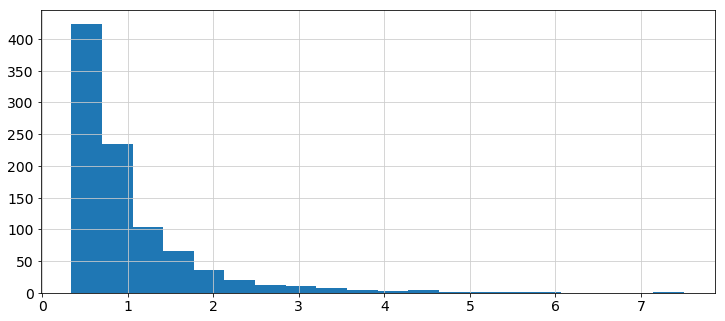

#time start: 0.0s
n_cell=931, n_gene=1770


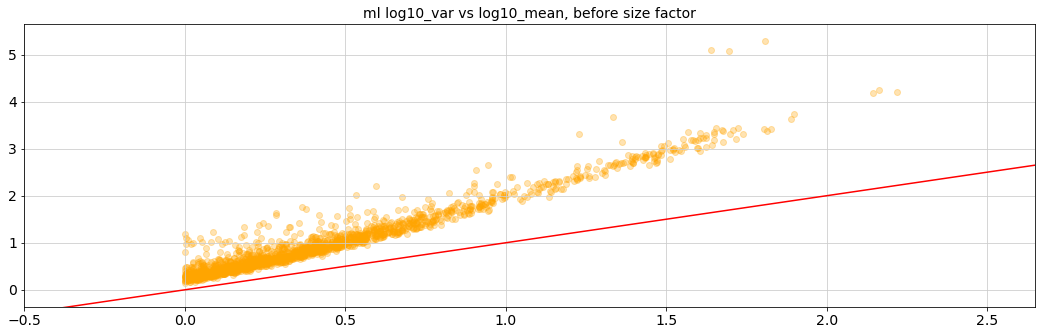

M1, sf=1.0000
M2, sf=1.6219
#time total: 0.3454s



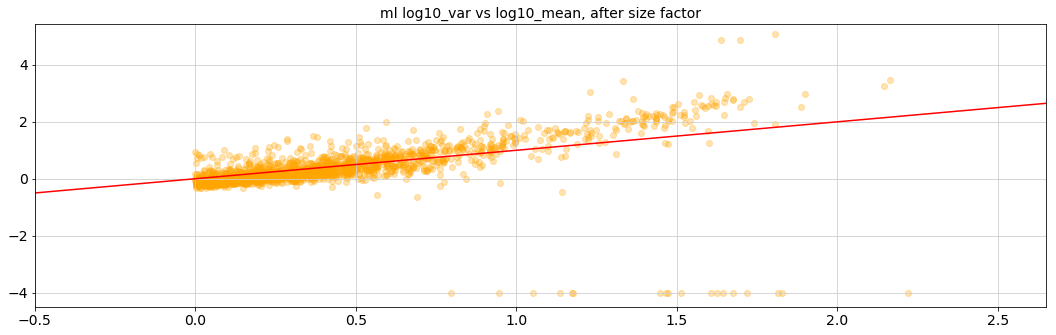

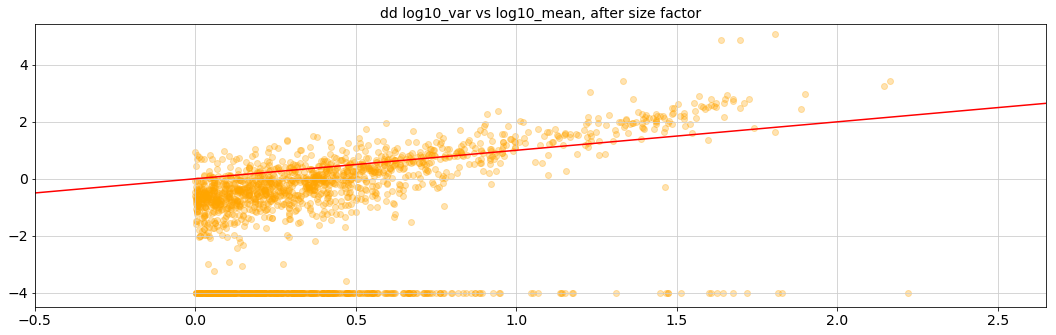

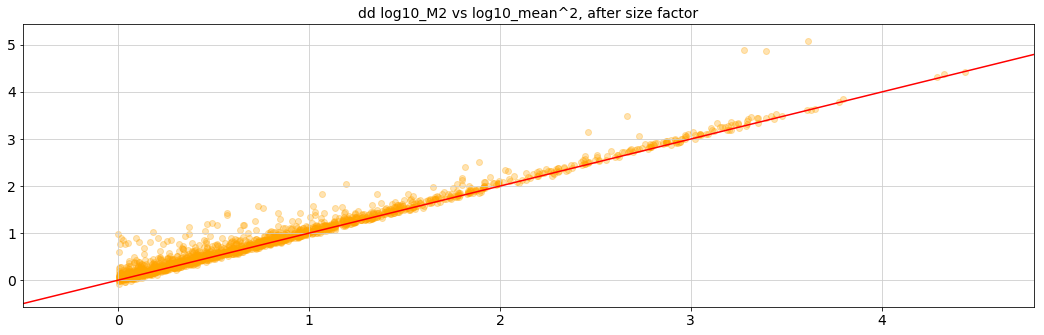

In [233]:
data_1k = dataset['brain1k'].copy()
sf_1k = sd.sf(data_1k,verbose=True)
sc.pp.filter_genes(data_1k,min_counts=1*data_1k.shape[0])
M_1k,M_ml_1k,gene_list_1k = sd.dd_moment_anndata(data_1k,gamma_c=sf_1k,verbose=True)

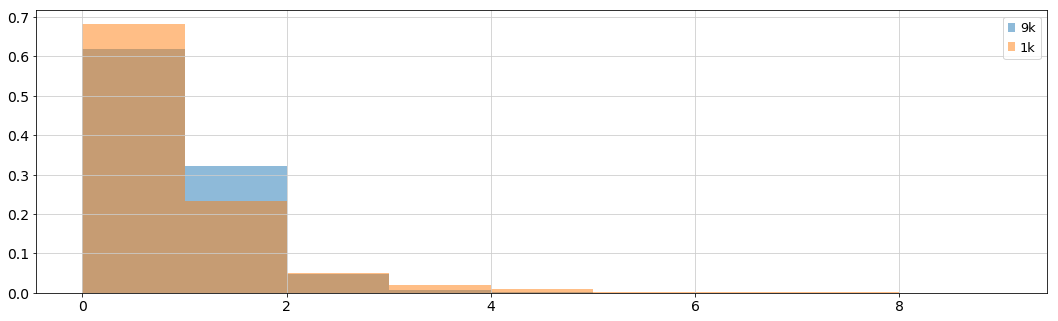

In [234]:
plt.figure(figsize=[18,5])
bins=np.arange(10)
plt.hist(sf_9k,weights=1/sf_9k.shape[0]*np.ones([sf_9k.shape[0]]),alpha=0.5,bins=bins,label='9k')
plt.hist(sf_1k,weights=1/sf_1k.shape[0]*np.ones([sf_1k.shape[0]]),alpha=0.5,bins=bins,label='1k')
plt.legend()
plt.show()

In [89]:
M1,M2 = M_9k[:,0],M_9k[:,1]
idx_M20 = np.where(M2==0)[0]
gene_M20 = list(data_9k.var_names[idx_M20])
cts_Farp2 = np.array((data_9k[:,'Farp2'].X),dtype=int)

In [98]:
cts_Farp2_ = np.array((data_1k[:,'Farp2'].X),dtype=int)

ml: above=173, below=1000, avg_r log10(cv2/cv1)=-0.127
dd: above=460, below=632, avg_r log10(cv2/cv1)=-0.111


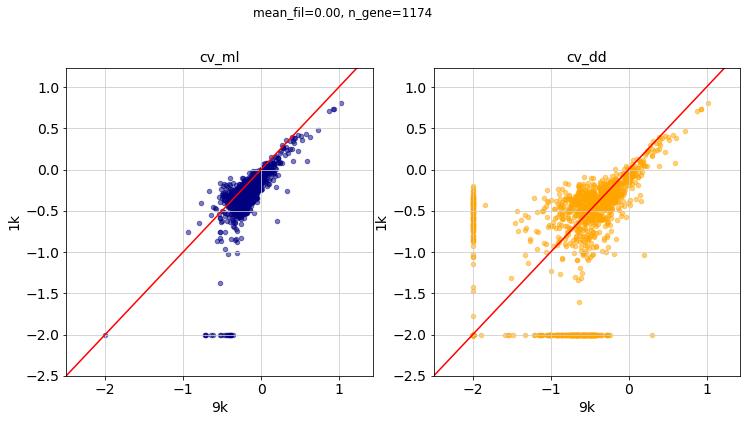

In [238]:
sd.fig_xx_cv(M_9k,M_ml_9k,M_1k,M_ml_1k,gene_list_9k,gene_list_1k,['9k','1k'],mean_fil=0)    

In [ ]:
M,M_ml,M_nsf,M_ml_nsf,gene_list,gene_list_nsf = {},{},{},{},{},{}

for dname in dataset.keys():
    if dname=='brain1.3m': break
    print('## processing %s ...'%dname)
    print('# n_cell=%d, n_gene=%d'%(dataset[dname].shape[0],dataset[dname].shape[1]))
    temp = dataset[dname].copy()
    sc.pp.filter_cells(temp, min_counts=0.01*temp.shape[1])
    gamma_c = sd.sf(temp,verbose=False)
    sc.pp.filter_genes(temp,min_counts=0.01*temp.shape[0])
    print('# after filtering: n_cell=%d, n_gene=%d'%(temp.shape[0],temp.shape[1]))
    M_,M_ml_,gene_list_ = sd.dd_moment_anndata(temp,gamma_c=gamma_c,verbose=False)
    M_nsf_,M_ml_nsf_,gene_list_nsf_ = sd.dd_moment_anndata(temp,gamma_c=None,verbose=False)
    
    M[dname],M_ml[dname],M_nsf[dname],M_ml_nsf[dname],gene_list[dname],gene_list_nsf[dname] = \
    M_,M_ml_,M_nsf_,M_ml_nsf_,gene_list_,gene_list_nsf_
    print('\n')
#     if dname=='PBMC8k': break

# subsample experiment

In [45]:
## subsampling experiment 
d1 = dataset['brain9k']
sc.pp.filter_cells(d1,min_counts=0.01*d1.shape[1])
sf1 = sd.sf(d1,verbose=False)
sc.pp.filter_genes(d1,min_counts=0.01*d1.shape[0])

d2 = dataset['brain1k']
sc.pp.filter_cells(d2,min_counts=0.01*d2.shape[1])
sf2 = sd.sf(d2,verbose=False)
sc.pp.filter_genes(d2,min_counts=0.01*d2.shape[0])

In [50]:
d2.n_vars

12343

In [48]:
d2.obs

,n_counts
AAACCTGGTCTCGTTC-1,9419.0
AAACGGGAGCCACGTC-1,5717.0
AAACGGGAGCGAGAAA-1,5189.0
AAACGGGCACACCGAC-1,13760.0
AAACGGGTCGCCAGCA-1,15808.0
AAACGGGTCGCGTTTC-1,7927.0
AAACGGGTCGGCGGTT-1,12496.0
AAAGATGAGGCTCAGA-1,10766.0
AAAGTAGGTACAGACG-1,6417.0
AAAGTAGGTTGGACCC-1,7341.0


Nr=11531
gamma_c [0.33993718 0.33996944 0.3402598  4.38292661 6.16535087 7.50411367]


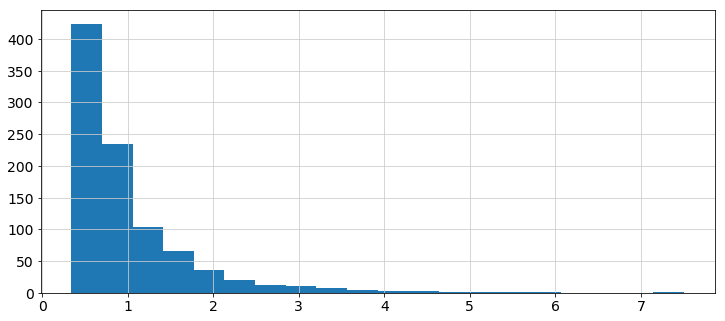

array([[0.81680316],
       [0.49577063],
       [0.44998318],
       [1.19324887],
       [1.37084877],
       [0.68741888],
       [1.08363652],
       [0.93361324],
       [0.55647373],
       [0.63660175],
       [0.40575665],
       [2.19493628],
       [0.56887448],
       [0.83536094],
       [0.49620423],
       [0.63434708],
       [0.4185043 ],
       [0.62151271],
       [0.38329652],
       [0.35571998],
       [0.39023402],
       [0.46090972],
       [3.03012371],
       [0.69609076],
       [1.14798176],
       [2.23604083],
       [0.6863783 ],
       [0.58535105],
       [0.57234323],
       [1.01608264],
       [2.57129526],
       [0.39214182],
       [0.51025265],
       [0.76685321],
       [0.85495937],
       [0.75835478],
       [0.57711273],
       [0.41035277],
       [0.96197021],
       [2.28971982],
       [0.94800854],
       [0.96205693],
       [0.77205634],
       [0.56341124],
       [0.35832155],
       [1.85309124],
       [1.45921504],
       [0.378

In [43]:
sd.sf(d2)

Nr=7346
gamma_c [0.30261216 0.30261216 0.3033101  3.06700076 5.10077825 7.93788576]


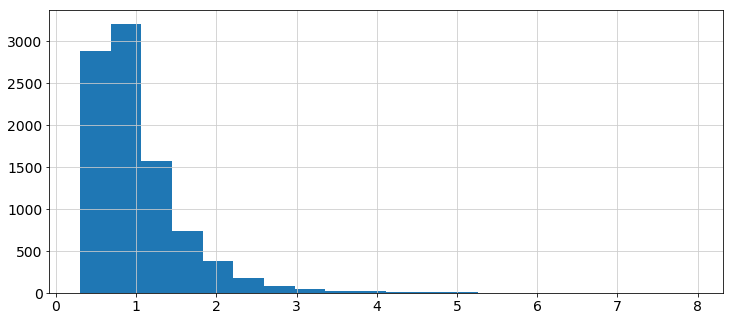

array([[0.43166134],
       [1.21643829],
       [0.38837269],
       ...,
       [2.54014516],
       [0.51674122],
       [1.16961026]])

In [42]:
sd.sf(d1)

In [40]:
d2.X.sum()

10735866.0

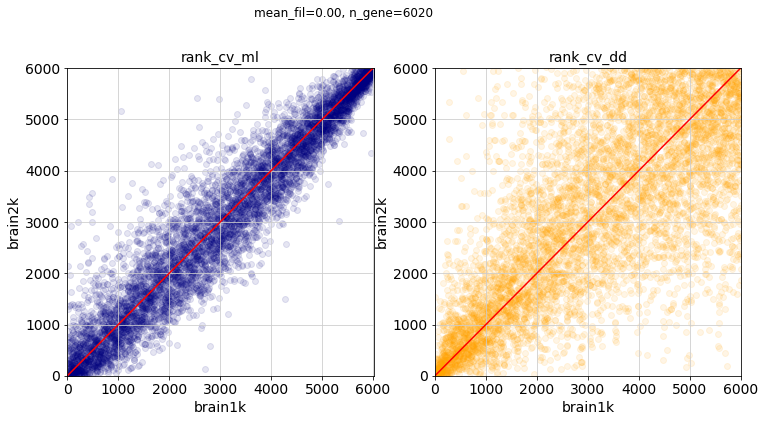

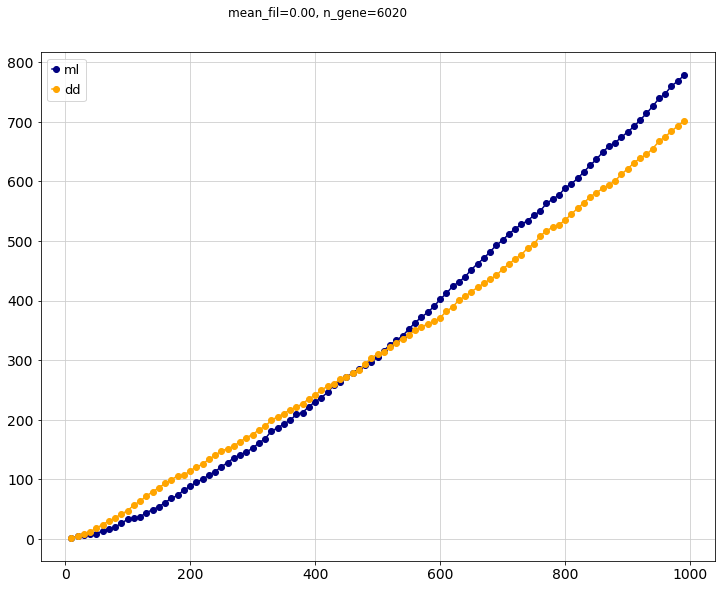

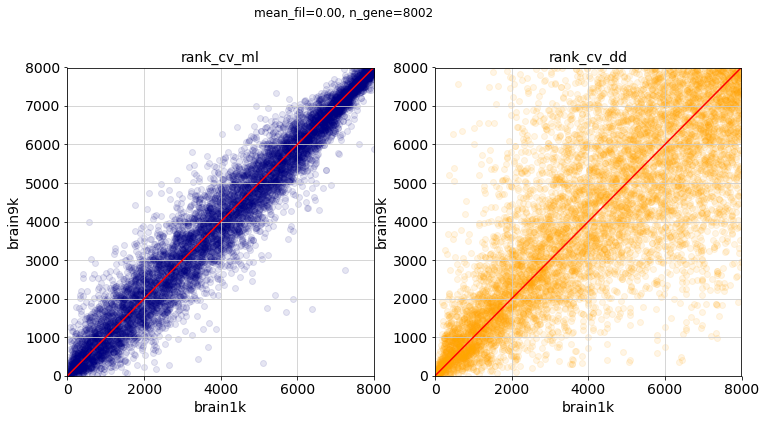

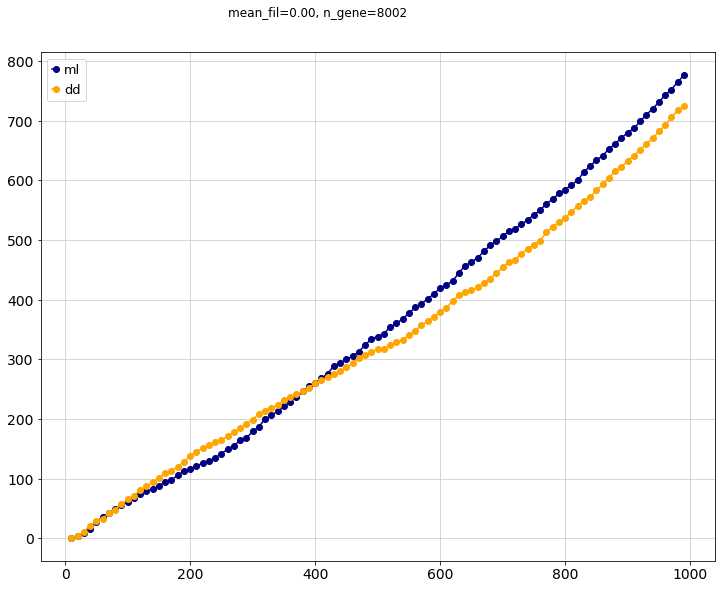

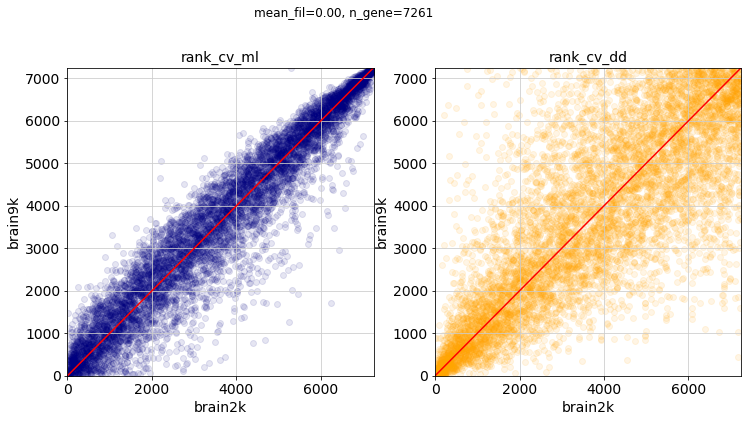

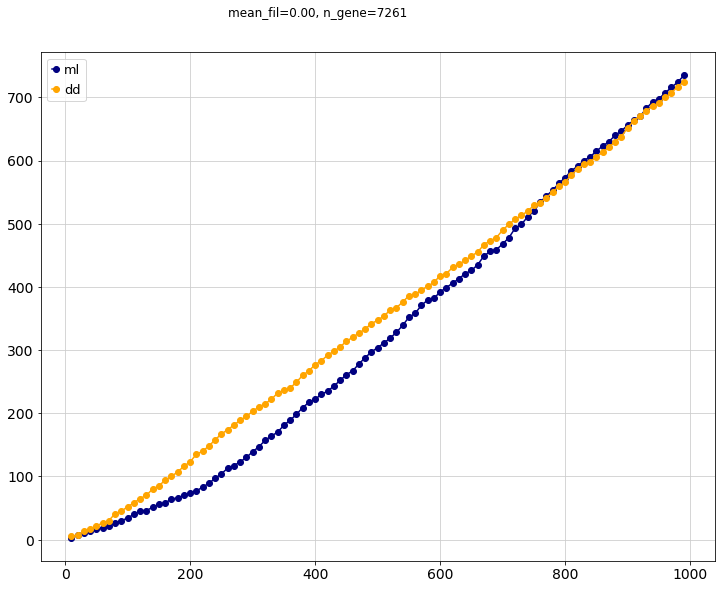

In [23]:
# plot_list = [['brain1k','brain2k'],['brain1k','brain9k'],['brain2k','brain9k']]
for pair in plot_list:
    d1,d2=pair
    sd.fig_xx_rank(M[d1],M_ml[d1],M[d2],M_ml[d2],gene_list[d1],gene_list[d2],[d1,d2],mean_fil=0)

In [ ]:
## MSE



